In [1]:
from pyspark import SparkContext
import datetime
from csv import reader
import pandas            as pd
import numpy             as np
import matplotlib
import matplotlib.pyplot as plt
import sys #only needed to determine Python version number
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
sc = SparkContext()

In [3]:
filepath = r'./NYPD_Complaint_Data_Historic.csv'
df = sc.textFile(filepath).map(lambda l: reader([l]).__next__())
header = df.first()
df = df.filter(lambda line: line != header).cache() # filter out header

### Data Cleaning

In [4]:
def transform(array):
    array[1] = datetime.datetime.strptime(array[1], '%m/%d/%Y')
    array[2] = datetime.datetime.strptime(array[2], '%H:%M:%S').time()
    return array

#replace year 1015
def replaceYear2015to2015(array):
    array[1] = array[1].replace('1015', '2015')
    return array

def replaceTime24to00(array):
    array[2] = array[2].replace('24:00:00', '00:00:00')
    return array

t = df.filter(lambda array: array[1] != '' and array[2] != '') \
    .map(replaceYear2015to2015) \
    .map(replaceTime24to00) \
    .map(transform) \
    .filter(lambda array: (array[1].year >= 2006 and array[1].year <= 2015))

In [5]:
def timeMap(x):
    if x[0].hour >= 0 and x[0].hour < 6:
        return ('Midnight',1)
    elif x[0].hour >= 6 and x[0].hour < 12:
        return ('Morning', 1)
    elif x[0].hour >= 12 and x[0].hour < 18:
        return ('Afternoon', 1)
    else:
        return ('Evening', 1)

timeCount = t.map(timeMap) \
            .reduceByKey(lambda x, y: x + y) \

### Assumption 1:  the Time period of a day And the Residence crime

In [6]:
# This operation return the statistic data that crime occur inside the residence
assump_1 = t.map(lambda x: (x[2], x[15], x[16]))\
            .filter(lambda x: 'INSIDE' in str(x[1]) and 'RESIDENCE' in str(x[2]))\
            .map(timeMap)\
            .reduceByKey(lambda x, y: x + y)

In [7]:
assump_1_data = assump_1.collect()

In [8]:
assump_1_data

[('Afternoon', 465993),
 ('Morning', 356396),
 ('Midnight', 243796),
 ('Evening', 469017)]

In [9]:
type(assump_1_data)

list

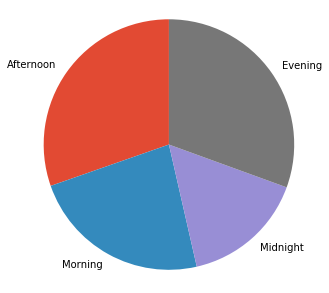

In [55]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_1_data)[:, 1], labels = np.array(assump_1_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig.set_size_inches(5, 5)

### Assumption 2：Time Period and the Street Crime

In [11]:
# This operation return the statistic data that crime occur inside the residence
assump_2 = t.map(lambda x: (x[2], x[16]))\
            .filter(lambda x: 'STREET' in str(x[1]))\
            .map(timeMap)\
            .reduceByKey(lambda x, y: x + y)

In [12]:
assump_2_data = assump_2.collect()

In [13]:
assump_2_data

[('Afternoon', 487580),
 ('Morning', 233245),
 ('Midnight', 351781),
 ('Evening', 623028)]

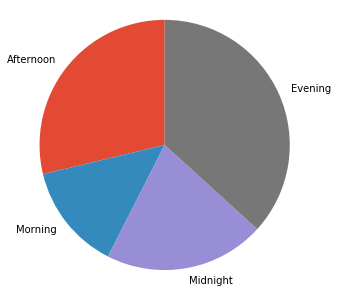

In [54]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_2_data)[:, 1], labels = np.array(assump_2_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig.set_size_inches(5, 5)

### Assumption3: Park and Time Period

In [15]:
# This operation return the statistic data that crime occur inside the residence
assump_3 = t.map(lambda x: (x[2], x[17]))\
            .filter(lambda x: len(x[1]) > 0)\
            .map(timeMap)\
            .reduceByKey(lambda x, y: x + y)

In [16]:
assump_3_data = assump_3.collect()

In [17]:
assump_3_data

[('Afternoon', 3090), ('Morning', 833), ('Midnight', 731), ('Evening', 2945)]

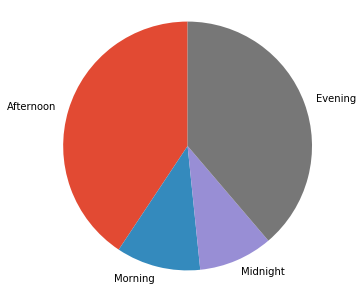

In [53]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_3_data)[:, 1], labels = np.array(assump_3_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig.set_size_inches(5, 5)

### Assumption4: Residence And Level of offense

In [31]:
assump_4 = t.map(lambda x: (x[11], x[16]))\
            .filter(lambda x: 'RESIDENCE' in x[1])\
            .map(lambda x: (x[0], 1))\
            .reduceByKey(lambda x, y: x + y)

In [32]:
assump_4_data = assump_4.collect()

In [33]:
assump_4_data

[('FELONY', 560415), ('VIOLATION', 354841), ('MISDEMEANOR', 1012439)]

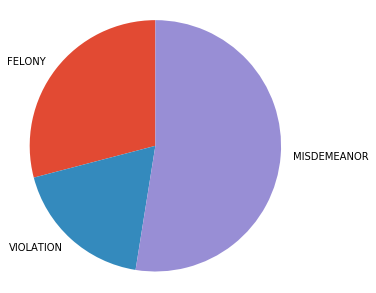

In [52]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_4_data)[:, 1], labels = np.array(assump_4_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig.set_size_inches(5, 5)

### Assumption5: Parks And Level of offence

In [39]:
assump_5 = t.map(lambda x: (x[11], x[17]))\
            .filter(lambda x: len(x[1]) > 0)\
            .map(lambda x: (x[0], 1))\
            .reduceByKey(lambda x, y: x + y)

In [40]:
assump_5_data = assump_5.collect()

In [41]:
assump_5_datata

[('FELONY', 2372), ('VIOLATION', 400), ('MISDEMEANOR', 4827)]

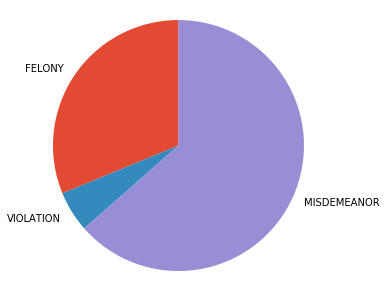

In [51]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_5_data)[:, 1], labels = np.array(assump_5_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig.set_size_inches(5, 5)

## Dig into Central Park

### Assumption6: Central Park and Level of offence

In [43]:
assump_6 = t.map(lambda x: (x[11], x[17]))\
            .filter(lambda x: 'CENTRAL PARK' in str(x[1].strip()))\
            .map(lambda x: (x[0], 1))\
            .reduceByKey(lambda x, y: x + y)

In [44]:
assump_6_data = assump_6.collect()

In [46]:
assump_6_data

[('FELONY', 151), ('VIOLATION', 56), ('MISDEMEANOR', 338)]

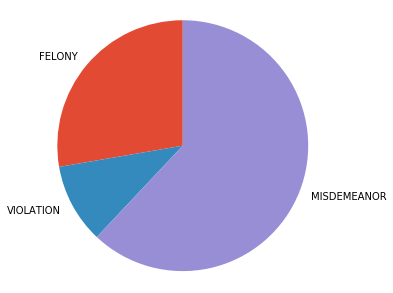

In [50]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_6_data)[:, 1], labels = np.array(assump_5_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig.set_size_inches(5,5)

### Assumption6: Central Park Weather Information And 

In [29]:
df_weather = sc.textFile('./central_park_temperature.csv')\
            .map(lambda line: line.split(","))\
            .filter(lambda line: len(line)<=1)\
            .map(lambda x: (datetime.datetime.strptime(x[0], '%m/%d/%Y'), x[1]))
df_weather = 

In [30]:
data = df_weather.collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 14.0 failed 1 times, most recent failure: Lost task 1.0 in stage 14.0 (TID 248, localhost, executor driver): java.io.FileNotFoundException: /home/jovyan/work/big-data-analytics/chuanlong/central_park_temperature.csv (Permission denied)
	at java.io.FileInputStream.open0(Native Method)
	at java.io.FileInputStream.open(FileInputStream.java:195)
	at java.io.FileInputStream.<init>(FileInputStream.java:138)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileInputStream.<init>(RawLocalFileSystem.java:106)
	at org.apache.hadoop.fs.RawLocalFileSystem.open(RawLocalFileSystem.java:202)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSInputChecker.<init>(ChecksumFileSystem.java:143)
	at org.apache.hadoop.fs.ChecksumFileSystem.open(ChecksumFileSystem.java:346)
	at org.apache.hadoop.fs.FileSystem.open(FileSystem.java:769)
	at org.apache.hadoop.mapred.LineRecordReader.<init>(LineRecordReader.java:109)
	at org.apache.hadoop.mapred.TextInputFormat.getRecordReader(TextInputFormat.java:67)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.liftedTree1$1(HadoopRDD.scala:252)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.<init>(HadoopRDD.scala:251)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:211)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:102)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1958)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:934)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.io.FileNotFoundException: /home/jovyan/work/big-data-analytics/chuanlong/central_park_temperature.csv (Permission denied)
	at java.io.FileInputStream.open0(Native Method)
	at java.io.FileInputStream.open(FileInputStream.java:195)
	at java.io.FileInputStream.<init>(FileInputStream.java:138)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileInputStream.<init>(RawLocalFileSystem.java:106)
	at org.apache.hadoop.fs.RawLocalFileSystem.open(RawLocalFileSystem.java:202)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSInputChecker.<init>(ChecksumFileSystem.java:143)
	at org.apache.hadoop.fs.ChecksumFileSystem.open(ChecksumFileSystem.java:346)
	at org.apache.hadoop.fs.FileSystem.open(FileSystem.java:769)
	at org.apache.hadoop.mapred.LineRecordReader.<init>(LineRecordReader.java:109)
	at org.apache.hadoop.mapred.TextInputFormat.getRecordReader(TextInputFormat.java:67)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.liftedTree1$1(HadoopRDD.scala:252)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.<init>(HadoopRDD.scala:251)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:211)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:102)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more
